#### This notebook demonstrates what runs on the backend. 

NOTE--color quantization performed according to scikit-learn docs: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

#### Read image to a numpy array
We use PIL, the Python Imaging Library, in order to read the image from either a filepath (or from a request in the backend)

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

size = 100
im = Image.open("images/sunflower.jpg") # create PIL image
im.thumbnail([size,size], Image.LANCZOS)
imageArray = np.asarray(im) # read into numpy array


#### Train image on Mini-batch K-means

We use mini batch K-means as it's faster and we're working with relatively small amounts of data. This will ensure the model runs quicker on the backend and serve a result to the user quicker.

In [31]:
w, h, d = tuple(imageArray.shape) # get width and height of image

n_colors = 10 # number of colors to use

flattenedImageArray = np.reshape(imageArray, (w * h, d)) # flatten image array for training

kmeans = MiniBatchKMeans(n_clusters = n_colors, n_init = 'auto', random_state = 0).fit( # train kmeans model on flattened array, n_init = auto means kmeans
    flattenedImageArray                                                                 # will have one run with centroid sampled based on contribution to 
)                                                                                       # inertia and not just randomly

#### Image reconstruction

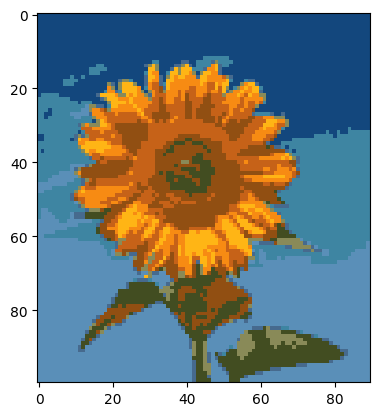

In [33]:
# get labels for original image, this will generate a 1-d array that corresponds 
# to the original flattened array where each element corresponds to an index into the codebook (i.e. kmeans.cluster_centers_)
labels = kmeans.predict(flattenedImageArray) 

def convertPaletteToDMC(palette, dmc_url):
    """
    ARGS:
    palette: array-like of cluster centers
    dmc_url: url containing dataset of floss colors
    PURPOSE:
    This function accepts a palette (codebook) and converts it into 
    RGB colors that represent DMC floss.
    """
    dmc_df = pd.read_csv(dmc_url, header = None)
    return np.asarray([resolvePixel(pix, dmc_df) for pix in palette])
    
def resolvePixel(pixel, df):
    """
    ARGS:
    pixel: array of length 3 containing rgb values for a pixel you want to map to a DMC color
    df: pandas DataFrame containing DMC floss and their RGB values. expects columns 2-4 to be RGB, last col to be color description
    PURPOSE:
    Computes which dmc color is the closest in terms of euclidean distance (plot rgb values on 3d grid, pick the closest)
    """
    bestDist = 99999 # initialize distance to some large number
    bestColor = -1   # initialize color to some dummy value
    # bestDescription = "" # in case you want to use description
    for color in df.iterrows():
        dist = np.sqrt(np.sum((pixel-color[1][1:-1])**2)) # compute euclidean distance between DMC color and pixel
        if dist < bestDist: # if it does better, update
            bestDist = dist
            bestColor = color[1][1:-1]
            # bestDescription = color[1][4]
    return np.asarray(bestColor) # return as numpy array
    

def gen_image(palette, labels, w, h):
    return palette[labels].reshape(w, h, -1) # -1 means infer third dimension (should be 3)

palette = convertPaletteToDMC(kmeans.cluster_centers_, "https://storage.googleapis.com/dmc-cathacks/dmc.csv")
finalImageArray = gen_image(palette, labels, w, h).astype(np.uint8) # convert floats to uint8 for PIL
finalImage = Image.fromarray(finalImageArray) # create PIL image from output array

# plt.imshow(finalImage) # uncomment to show result, hidden to not distort GitHub language percentages

                                    